<a href="https://colab.research.google.com/github/josebogot4/Proyecto_MLDS/blob/main/Predicci%C3%B3nPrecio_accion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Predicción del precio de cierre de acciones**


## **1. Descripción del negocio**
En los mercados financieros se negocia un tipo de activo de renta variable llamado acción. Las acciones representan una proporción de cápital social de una empresa. En un periodo de tiempo (minutos, horas, días, semanas, meses, años) las acciones tienen varios estados; el precio de apertura, el precio máximo, el precio mínimo, precio de cierre, precio de cierre ajustado y volumen o cantidad de transacciones que se hicieron con ese activo en un subperioodo de tiempo.

Todos estos datos son muestra del recorrido del costo de la acción durante ese periodo y para personas que negocian con acciones es importante reconocer los movimientos del precio de una acción esto con el fin de tomar decisiones que aporten futuras ganancias, además de la reducción de pérdidas.  

### **1.1 Objetivo del proyecto**

El proyecto tiene como objetivo, seleccionar la característica -Precio de cierre- de una acción en un periodo de tiempo determinado, y a partir de los datos históricos de la acción, predecir los futuros valores del precio de cierre.

## **2. Entendimiento de los datos**

En primera instancia, importamos las librerias y herramientas necesarias para realizar el modelo de predicción y el análisis necesario.

In [ ]:
#importar librerias a usar
import numpy as np
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
import yfinance as yf
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

Los datos se descargan directamente de la pagina Yahoo-finance en formato DataFrame, lo cual nos da una visión clara de la forma en que están organizados y permite seleccionar las características de manera sencilla.

In [ ]:
#Descarga de los datos
data = yf.download('AAPL', start='2016-01-01', end='2023-01-01')
data1 = yf.download('TSLA', start='2016-01-01', end='2023-01-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Se han seleccionado las acciones de Apple y Tesla. Una vez descargadas, se procede seleccionar la caraterística -Precio de cierre-. La gráfica al final de esta celda permite visualizar el movimiento del precio de cierre en ambas acciones, tomadas en periodos de tiempo -día- desde el año 2016-01-01 hasta el año 2023-01-01. 

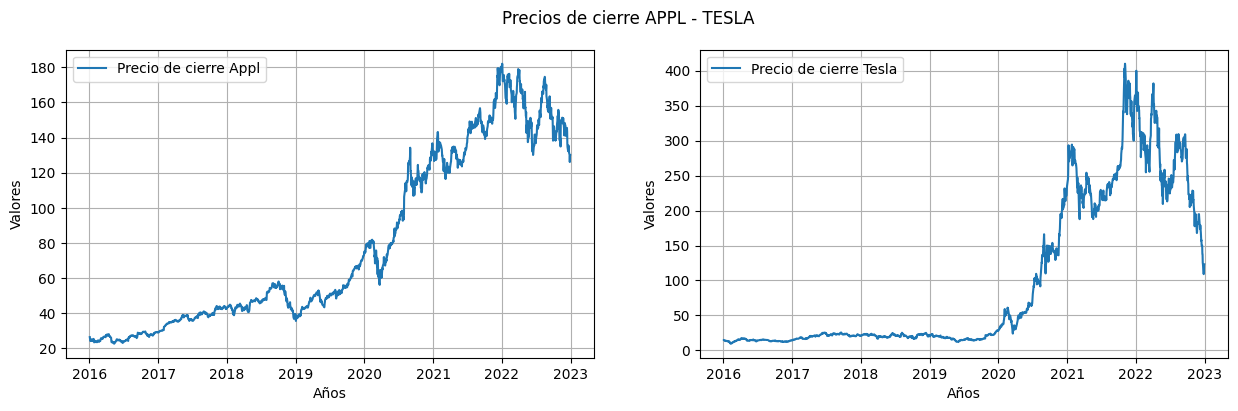

In [ ]:
#Seleccionar característica para realizar análisis
data_topred = data['Close']
data_topred1 = data1['Close']

#Gráficas correspondientes a los precios de cierre de las acciones elegidas para realizar la predicción
fig, (ax1, ax2) = plt.subplots(1, 2, dpi = 100, figsize=(15, 4))
fig.suptitle('Precios de cierre APPL - TESLA')

ax1.plot(data_topred, label = 'Precio de cierre Appl')
ax1.set(xlabel='Años', ylabel='Valores')
ax1.legend()
ax1.grid(True)

ax2.plot(data_topred1, label = 'Precio de cierre Tesla')
ax2.set(xlabel='Años', ylabel='Valores')
ax2.legend()
ax2.grid(True)

plt.show()

In [ ]:
#Código para gráficas
p=0.3
n_train = int(len(data1['Close'])*(1-p))
train1,  test1 = data1['Close'][: n_train], data1['Close'][n_train:]

n_train = int(len(data_topred)*(1-p))
train,  test = data_topred[: n_train], data_topred[n_train:]

Seleccionamos la característica y mostramos la información necesaria, note que no hay valores faltantes, por lo cual no es necesario realizar algún tipo de limpieza en los datos.

In [ ]:
#Datos par generar las particiones, los datos estarán en formato de arreglos de numpy.
serie_actionpd = data['Close']
serie_accion = data['Close'].values
print('Información de Apple', serie_actionpd.info)

serie_actionpd1 = data1['Close']
serie_accion1 = data1['Close'].values
print('Información de tesla', serie_actionpd1.info)


Información de Apple <bound method Series.info of Date
2016-01-04     26.337500
2016-01-05     25.677500
2016-01-06     25.174999
2016-01-07     24.112499
2016-01-08     24.240000
                 ...    
2022-12-23    131.860001
2022-12-27    130.029999
2022-12-28    126.040001
2022-12-29    129.610001
2022-12-30    129.929993
Name: Close, Length: 1762, dtype: float64>
Información de tesla <bound method Series.info of Date
2016-01-04     14.894000
2016-01-05     14.895333
2016-01-06     14.602667
2016-01-07     14.376667
2016-01-08     14.066667
                 ...    
2022-12-23    123.150002
2022-12-27    109.099998
2022-12-28    112.709999
2022-12-29    121.820000
2022-12-30    123.180000
Name: Close, Length: 1762, dtype: float64>


## **3. Selección de datos**
En esta seccción definimos las funciones necesaras para realizar las particiones necesarias sobre las que vamos a aplicar el modelo predictivo.

###**3.1 Función de partición**
La función -data_partition- permite seleccionar los datos de partición y de prueba.

In [ ]:
 #Partición de series de tiempo

def data_partition(serie, p):
    """Entrada:
            series: serán los datos del dataset a los que queramos hallar su predicción. Arreglo de Numpy de dimensiones (n,)
            p: porcentaje de los datos que serán destinados a la partición de prueba.
       salida: 
            serie_train: Arreglo de NumPY con partición de entrenamiento de la serie de tiempo
            serie_test: Arreglo de Numpy con la partición de prueba en la serie de tiempo.
    """
    n = len(serie)
    serie_train = serie[ :int(np.around(n*(1-p)))]
    serie_test = serie[int(np.around(n*(1-p))):]
    
    return serie_train, serie_test

In [ ]:
#Particiones de entrenamiento y prueba acción Apple
S_train, S_test = data_partition(serie_accion, p=0.3)
print('Tamñaño de partición de entrenamiento, Apple: \t{}'.format(S_train.shape))
print('Tamñaño de partición de prueba, Apple: \t{}'.format(S_test.shape))

#Particiones de entrenamiento y prueba acción Tesla
S_trainT, S_testT = data_partition(serie_accion1, p=0.3)
print('Tamñaño de partición de entrenamiento, Tesla: \t{}'.format(S_trainT.shape))
print('Tamñaño de partición de prueba, Tesla: \t{}'.format(S_testT.shape))

Tamñaño de partición de entrenamiento, Apple: 	(1233,)
Tamñaño de partición de prueba, Apple: 	(529,)
Tamñaño de partición de entrenamiento, Tesla: 	(1233,)
Tamñaño de partición de prueba, Tesla: 	(529,)


En la siguiente celda se puede visualizar los datos que fueron tomados para entrenamiento y prueba de sus respectivas acciones.

<function matplotlib.pyplot.show(close=None, block=None)>

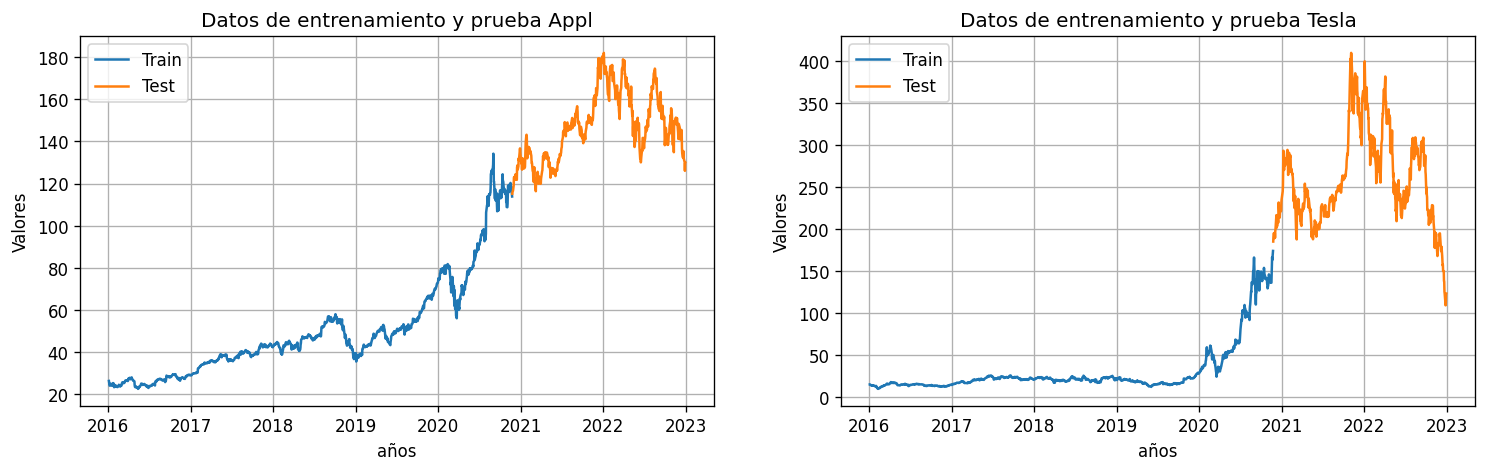

In [ ]:
#Gráfica de los datos de entrenamiento y prueba
n = len(data_topred)

fig, (ax1, ax2) = plt.subplots(1, 2, dpi=120, figsize = (15, 4))
ax1.plot(serie_actionpd.loc[:'2020-11-23'].index, S_train, label = 'Train')
ax1.plot(serie_actionpd.loc['2020-11-24':].index, S_test, label='Test')
ax1.set(xlabel='años', ylabel='Valores', title='Datos de entrenamiento y prueba Appl')
ax1.grid(True)
ax1.legend()

ax2.plot(serie_actionpd1.loc[:'2020-11-23'].index, S_trainT, label = 'Train')
ax2.plot(serie_actionpd1.loc['2020-11-24':].index, S_testT, label='Test')
ax2.set(xlabel='años', ylabel='Valores', title='Datos de entrenamiento y prueba Tesla')
ax2.grid('True')
ax2.legend()

plt.show

###**3.2 Función ventanas temporales**
La siguiente función permite crear las ventanas temporales de entrenamiento y de prueba, aplicadas sobre los datos que retorna la función -data_partition-, es decir la particion de entrenamiento S_train, tendra su partición de entrenamiento y de prueba, los mismo aplica para la partición de prueba S_test.

In [ ]:
#Crear ventanas temporales

def windows(serie, w=1):
    """Entradas: 
                serie: Arreglo de NumPy de dimensión (m,), debe ser una serie de tiempo.
                w: tamaño de las ventanas
       Salida: 
                X: ventanas temporales de dimensión (m-w, w)
                y: el valor siguiente en la serie para cada ventana, debe tener dimensión (m-w)
    """

    n = serie.shape[0] - w
    X = np.empty((n, w))
    y = np.empty(n)

    for i in range(w, serie.shape[0]):
        X[i-w, 0:w] = serie[i-w: i]
        y[i-w] = serie[i]
    
    return X, y

Para nuestro caso de estudio, vamos a tomar ventanas de tamaño 30, es decir cada ventana tendrá una longitud de 30 días para su respectivo entrenamiento, lo mismo con la partición de prueba.

In [ ]:
#Generar las ventanas en los datos de entrenamiento y prueba Apple
S_train_window, y_train_window = windows(S_train, 30)
S_test_window, y_test_window = windows(S_test, 30)

print('Dimensión de las ventanas de entrenamiento, Apple: {}'.format(S_train_window.shape))
print('tamaño de las ventanas para predecir (entrenamiento) Apple: {}'.format(y_train_window.shape))
print('tamaño de las ventanas de entrenamiento (validación), Apple: {}'.format(S_test_window.shape))
print('tamaño de las ventanas de prueba (validación), Apple: {}'.format(y_test_window.shape))

Dimensión de las ventanas de entrenamiento, Apple: (1203, 30)
tamaño de las ventanas para predecir (entrenamiento) Apple: (1203,)
tamaño de las ventanas de entrenamiento (validación), Apple: (499, 30)
tamaño de las ventanas de prueba (validación), Apple: (499,)


In [ ]:
#Generar las ventanas en los datos de entrenamiento y prueba Tesla
S_trainT_window, y_trainT_window = windows(S_trainT, 30)
S_testT_window, y_testT_window = windows(S_testT, 30)

print('tamaño de las ventanas de entrenamiento, Tesla: {}'.format(S_trainT_window.shape))
print('tamaño de las ventanas para predecir (entrenamiento), Tesla: {}'.format(y_trainT_window.shape))
print('tamaño de las ventanas de entrenamiento (validación), Tesla: {}'.format(S_testT_window.shape))
print('tamaño de las ventanas de prueba (validación), Tesla: {}'.format(y_testT_window.shape))

tamaño de las ventanas de entrenamiento, Tesla: (1203, 30)
tamaño de las ventanas para predecir (entrenamiento), Tesla: (1203,)
tamaño de las ventanas de entrenamiento (validación), Tesla: (499, 30)
tamaño de las ventanas de prueba (validación), Tesla: (499,)


In [ ]:
#Ventanas correctas
print(S_train_window[:2])

[[26.33749962 25.67749977 25.17499924 24.11249924 24.23999977 24.63249969
  24.98999977 24.34749985 24.87999916 24.28249931 24.16500092 24.19750023
  24.07500076 25.35499954 24.86000061 24.99749947 23.35499954 23.52249908
  24.33499908 24.10750008 23.62000084 24.08749962 24.14999962 23.50499916
  23.75250053 23.74749947 23.56749916 23.42499924 23.49749947 24.15999985]
 [25.67749977 25.17499924 24.11249924 24.23999977 24.63249969 24.98999977
  24.34749985 24.87999916 24.28249931 24.16500092 24.19750023 24.07500076
  25.35499954 24.86000061 24.99749947 23.35499954 23.52249908 24.33499908
  24.10750008 23.62000084 24.08749962 24.14999962 23.50499916 23.75250053
  23.74749947 23.56749916 23.42499924 23.49749947 24.15999985 24.53000069]]


##**4. Modelamiento**

Para predecir los futuros valores del precio de cierre, usaremos el modelo de regresión basado en redes neuronales artificales -MLPRegressor-.

###**4.1 Modelo configurado manualmente***
En este apartado implementamos el modelo MLPRegresor en la función -mlp_predict- cuyos argumentos están especificados en la celda de definición, cabe anotar que los hiperparamétros fueron conseguidos manualmete y después de muchos intentos. En este caso, las iteraciones estándar (200) del modelo no permitian la convergencia del mismo por lo cual se tuvo que modificar manualmente hasta lograr la convergencia, junto con la tupla que contiene la cantidad de neuronas en las capas ocultas, para la cual se ensayó con varios tipos de tamaño, la final la tupla -(30, 15, 8)- fue la escogida. La función de activación fue modificada, usando -logistic-, -tanh-, -relu-, en este caso el mejor resultado lo tuvo la función de activación -relu-.

In [ ]:
#Modelo para predecir el siguiente valor de la serie 

def mlp_predict(X_train, y_train, X_test, solver, activation):
    """Entradas:
                solver: algoritmo de optimización 
                activation: función de activación (no linealidad al modelo)
                random_state: semilla aleatoria 
        Salidas:
                y_pred: prediccion
    """
    model=MLPRegressor(solver=solver,
                       activation = activation,
                       hidden_layer_sizes = (30, 15, 8),
                       max_iter=3000,
                       n_iter_no_change = 50,
                       validation_fraction=0.2,
                       random_state=1234)
    modeltrain=model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    return y_pred

In [ ]:
#Predicción de precios de cierre de Apple
y_predict=mlp_predict(S_train_window, y_train_window, S_test_window, solver='lbfgs',activation='relu')
print('Coeficiente de determinación R^2: {}'.format(r2_score(y_test_window, y_predict)))

Coeficiente de determinación R^2: 0.9617371506448522


In [ ]:
#Predicción de precios de cierre de Tesla
y_predictT = mlp_predict(S_trainT_window, y_trainT_window, S_testT_window, solver='lbfgs',activation='relu')

In [ ]:
print(f"Test Mean Squared Error: \t{mean_squared_error(y_test_window, y_predict):.4f}")
print(f"Test Mean Absolute Error: \t{mean_absolute_error(y_test_window, y_predict):.4f}")
print(f"Test Mean squared log error: \t{mean_squared_log_error(y_test_window, y_predict):.4f}")

Test Mean Squared Error: 	9.1465
Test Mean Absolute Error: 	2.3479
Test Mean squared log error: 	0.0004


In [ ]:
print(f"Test Mean Squared Error: \t{mean_squared_error(y_testT_window, y_predictT):.4f}")
print(f"Test Mean Absolute Error: \t{mean_absolute_error(y_testT_window, y_predictT):.4f}")
print(f"Test Mean squared log error: \t{mean_squared_log_error(y_testT_window, y_predictT):.4f}")

Test Mean Squared Error: 	204.1652
Test Mean Absolute Error: 	10.7239
Test Mean squared log error: 	0.0030


En la siguiente gráfica se muestra el valor obtenido por la predicción junto con el valor real.

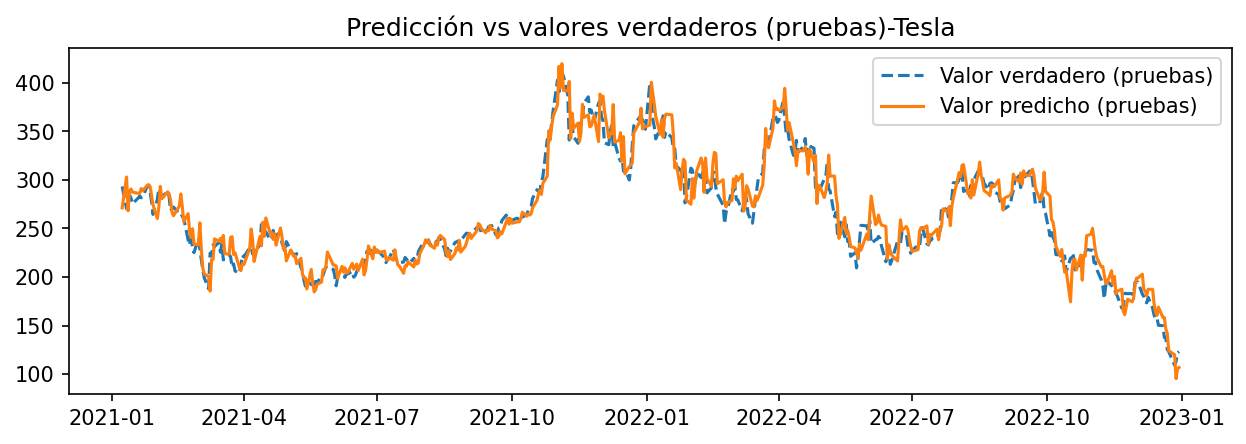

In [ ]:
x1 = test1.index[30:]

plt.figure(figsize=(10,3), dpi =150)
plt.plot(x1, y_testT_window, ls = "--", label="Valor verdadero (pruebas)")
plt.plot(x1, y_predictT, ls = '-', label="Valor predicho (pruebas)")
plt.title("Predicción vs valores verdaderos (pruebas)-Tesla")
plt.legend()

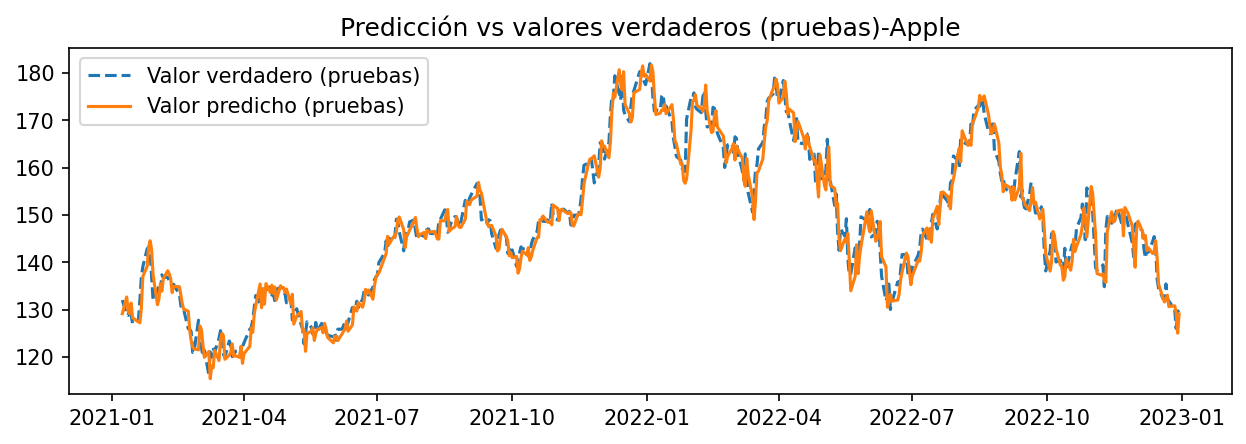

In [ ]:
x = test.index[30:]

plt.figure(figsize=(10,3), dpi =150)
plt.plot(x, y_test_window, ls = "--", label="Valor verdadero (pruebas)")
plt.plot(x, y_predict, ls = '-', label="Valor predicho (pruebas)")
plt.title("Predicción vs valores verdaderos (pruebas)-Apple")
plt.legend();

### **4.2 Modelo con GridSearchCV**

En esta sección implementamos el modelo -MLPRegressor- con GridSearchCV en busqueda de los mejores hiperparamétros para el correcto funcionamiento del modelo.

In [ ]:
#Implementación de GridSearchCV

def mlp_gsearch(X_train, y_train, param_gridsearch, k, seed = 1234):
    """Entradas: 
                X_train: arreglo de numpy de dimensiones (n, m)
                y_train: arreglo de numpy de dimensiones (n,)
                param_gridsearch: parametros del modelo a explorar
                k: numero de divisiones con TimeSeriesSplit
                seed: semilla aleatoria 
        salida: 
                gsearch: GridSearchCV entrenado con X_train, y_train
    """
    mlp = MLPRegressor(random_state=seed)
    mlp = mlp.fit(X_train, y_train)
    tsp = TimeSeriesSplit(n_splits=k)

    gsearchgrid = GridSearchCV(mlp,
                           cv = tsp,
                           param_grid=param_gridsearch)
    gsearch = gsearchgrid.fit(X_train, y_train)

    return gsearch

In [ ]:
#Buscar los mejores hiperparamétros para el modelo 

params = {
          'hidden_layer_sizes': [(10,), (50, 20), (30, 15,8), (100, 50, 25)], #incluimos la configuración definida anteriormente
          'max_iter': [10000],
          'activation': ['logistic', 'tanh','relu']
}

In [ ]:
#Implementación de GridSearchCV para realizar pruebas y encontrar los mejores hiperparametros para el modelo

gsearch = mlp_gsearch(S_train_window, y_train_window, params, k=5)
print('Mejor coeficiente de determinación (validación): {:.4f}'.format(gsearch.best_score_))
print('Mejores parámetros encontrados: {}'.format(gsearch.best_params_))
print('Mewjor coeficiente de determinación (particion de prueba): {:.4f}'.format(r2_score(y_test_window, y_predict)))

Mejor coeficiente de determinación (validación): 0.8577
Mejores parámetros encontrados: {'activation': 'relu', 'hidden_layer_sizes': (30, 15, 8), 'max_iter': 10000}
Mewjor coeficiente de determinación (particion de prueba): 0.9617


Como se puede observar, fue incluida la configuración manual encontrada anteriormente, en este caso se debió aumentar la cantidad máxima de iteraciones para que el modelo convergiera y mostrará el resultado.

Observe que el coeficiente de determinación $R^2=0.9617$ es el mismo que en el caso manual.

###**4.3 Valor próximo y n valores próximos**

En este apartado calculamos el valor próximo dada una ventana de serie de tiempo, para ello definimos la función -next_value- que después será implementada en la función -predict_nfuture_values- para calcular los n valores siguientes de una ventana de serie de tiempo dada. 

In [ ]:
#Función para el siguiente valor

def next_value(model, window):
    """ Entradas:
                model: modelo de regresión entrenado
                window: arreglo de numpy con dimensión (w,)
        salida: el siguiente valor predicho de la ventada dada
    """
    window = window.reshape(1, -1)
    next_value = model.predict(window)[-1]

    return next_value

In [ ]:
#Predecir los siguientes n valores

def predict_nfuture_values(model, window, n):
    """entradas: 
                model: modelo entrenado
                window: arreglo de numpy de tamaño (w,)
                n: número de valores a predecir 
        salida: 
                pred: arreglo de numpy con los valores predichos
    """
    pred = []
    for i in range(n):
        next_val = next_value(model, window)
        pred.append(next_val)
        window = np.concatenate((window[1:], [next_val]))
    predict = np.array(pred)
    
    return predict

In [ ]:
#Calcular predicción para la acción de apple 
windows_size = 30
windows_index = 40
n = 30 
window = S_test_window[windows_index]
y_true = y_test_window[windows_index: windows_index + n]
y_prediction = predict_nfuture_values(gsearch, window, n)

Por último, realizamos la gráfica para visualiuzar las predicciones y los valores reales para la acción de Appl.

<function matplotlib.pyplot.show(close=None, block=None)>

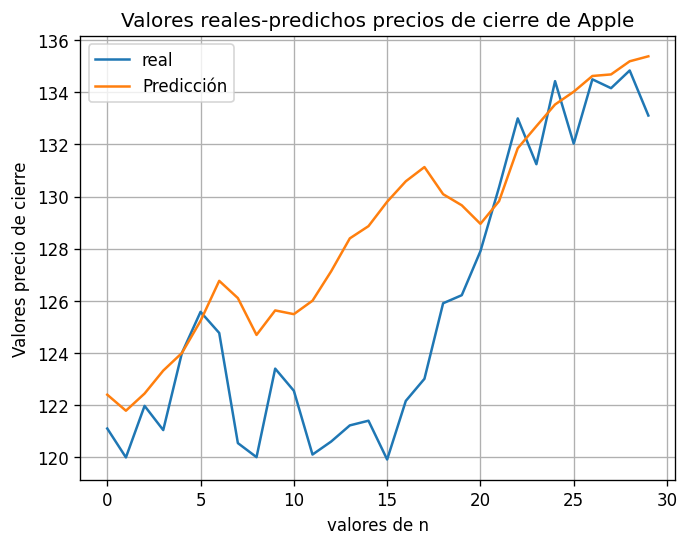

In [ ]:
#Graficar valores predichos y valores reales 
fig, ax = plt.subplots(dpi = 120)
ax.plot(y_true, label='real')
ax.plot(y_prediction, label = 'Predicción')
ax.set(xlabel='valores de n', ylabel='Valores precio de cierre', title='Valores reales-predichos precios de cierre de Apple')
ax.grid(True)
plt.legend()

plt.show

In [ ]:
#Calcular predicción para la acción de Tesla 
windows_size = 30
windows_index = 40
n = 30 
windowT = S_testT_window[windows_index]
y_trueT = y_testT_window[windows_index: windows_index + n]
y_predictionT = predict_nfuture_values(gsearch, windowT, n)

<function matplotlib.pyplot.show(close=None, block=None)>

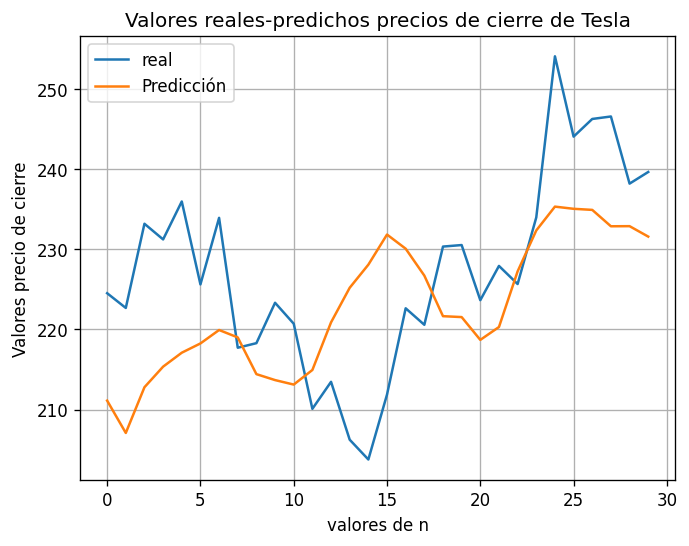

In [ ]:
#Graficar valores predichos y valores reales 
fig, ax1 = plt.subplots(dpi = 120)
ax1.plot(y_trueT, label='real')
ax1.plot(y_predictionT, label = 'Predicción')
ax1.set(xlabel='valores de n', ylabel='Valores precio de cierre', title='Valores reales-predichos precios de cierre de Tesla')
ax1.grid(True)
plt.legend()

plt.show

## **Conclusiones**

Si bien es cierto el hecho de predecir comportamientos en los precios de instrumentos finanacieros es bastante interesante, resulta igual de complejo ya que el comportamiento no solo está determinado por factores técnicos, además hay cuestiones políticas e intereses empresariales que juegan un papel importante en el comportamiento del precio de una acción. 

De este proyecto puedo concluir lo siguiente:

1.   El concepto de ventanas temporales es bastante útil en la aplicación del modelo, ya que se va entrenando el modelo en cada partición realizada, lo cual hace que el modelo se ajuste a ciertos patrones que le permiten reducir errores en la predicción corta. 
2.   El hecho de predecir un valor a partir de los $k$ valores anteriores se asemeja a las **Cadenas de Markov**, un proceso estocástico discreto y que carece de memoria para los eventos anteriores y en el cual tenemos que la probabilidad de un evento futuro se puede calcular por medio de la probabilidad de que haya ocurrido un evento anterior (probabilidad condicional).
3.   Los ajustes manuales para configurar un buen modelo requieren conocer como funciona el modelo con el cual se trabaja, también conocer la complejidad del problema que queremos resolver. Por lo tanto GridSearchCV puede considerarse como una excelente herramienta para probar hiperparámetros.
4. Aunque el modelo se ajusto de buena manera, según el coeficiente de determinación $R^2=0.9617$. Luego de hacer darle valores a $n$ por encima de 50, se puede ver la predicción del modelo no es buena, por lo cual hay que replantear como realizar un modelo que funcione de mejor manera. Observe la gráfica a continuación.

<function matplotlib.pyplot.show(close=None, block=None)>

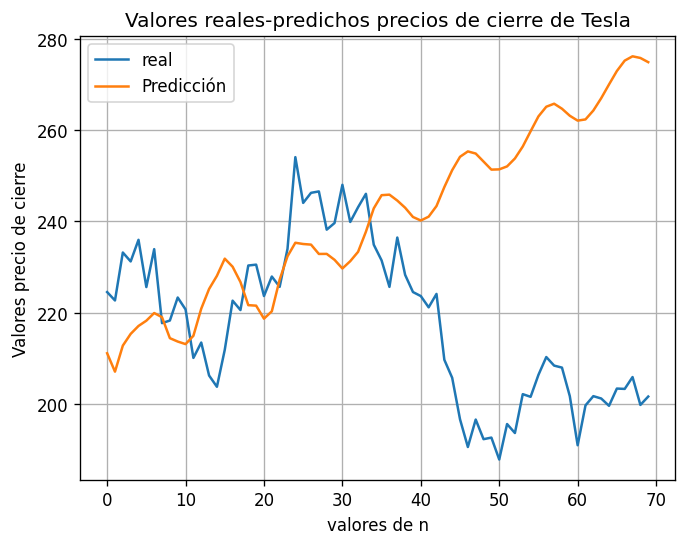

In [ ]:
#Calcular predicción para la acción de Tesla 
windows_size = 30
windows_index = 40
n = 70 
windowT = S_testT_window[windows_index]
y_trueT = y_testT_window[windows_index: windows_index + n]
y_predictionT = predict_nfuture_values(gsearch, windowT, n)

#Graficar valores predichos y valores reales 
fig, ax1 = plt.subplots(dpi = 120)
ax1.plot(y_trueT, label='real')
ax1.plot(y_predictionT, label = 'Predicción')
ax1.set(xlabel='valores de n', ylabel='Valores precio de cierre', title='Valores reales-predichos precios de cierre de Tesla')
ax1.grid(True)
plt.legend()

plt.show